In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [2]:
# Load dataset
df = pd.read_csv('social_media_viral_content_dataset.csv')
print("--- DATA BERHASIL DIMUAT ---")
df.head()

--- DATA BERHASIL DIMUAT ---


,post_id,platform,content_type,topic,language,region,post_datetime,hashtags,views,likes,comments,shares,engagement_rate,sentiment_score,is_viral
0,SM_100000,Instagram,text,Sports,ur,UK,2024-12-10 00:00:00,#tech #funny #music,2319102,122058,15800,861,0.0598,0.464,1
1,SM_100001,Instagram,carousel,Sports,ur,Brazil,2024-10-13 00:00:00,#news #fyp #funny #ai #trending,2538464,110368,11289,54887,0.0695,-0.800,1
2,SM_100002,YouTube Shorts,video,Technology,ur,UK,2024-05-03 00:00:00,#ai #news,1051176,87598,47196,44132,0.1702,0.416,0
3,SM_100003,X,text,Politics,ur,US,2024-08-04 00:00:00,#ai #funny,5271440,329465,774,59736,0.0740,0.877,1
4,SM_100004,YouTube Shorts,text,Education,es,US,2024-03-28 00:00:00,#news #ai #viral #funny #fyp,3186256,199141,5316,83105,0.0903,0.223,1


--- ANALISIS JANGKAUAN PLATFORM ---
platform
TikTok            4.358847e+06
Instagram         4.292936e+06
YouTube Shorts    4.263153e+06
X                 4.225450e+06
Name: views, dtype: float64


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_8764\8992118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_stats.index, y=platform_stats.values, palette='magma')


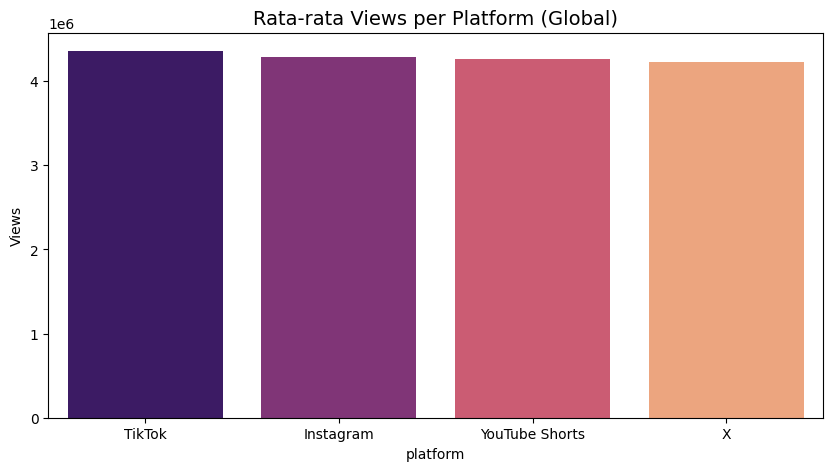


KESIMPULAN: Platform paling relevan untuk Otomotif adalah TIKTOK.


In [3]:
print("--- ANALISIS JANGKAUAN PLATFORM ---")
platform_stats = df.groupby('platform')['views'].mean().sort_values(ascending=False)
print(platform_stats)

plt.figure(figsize=(10, 5))
sns.barplot(x=platform_stats.index, y=platform_stats.values, palette='magma')
plt.title('Rata-rata Views per Platform (Global)', fontsize=14)
plt.ylabel('Views')
plt.show()

print(f"\nKESIMPULAN: Platform paling relevan untuk Otomotif adalah {platform_stats.index[0].upper()}.")

In [4]:
# LABELING STRATEGIS: Target views di atas 5 Juta sesuai kebutuhan studi kasus
df['is_high_view'] = (df['views'] > 5000000).astype(int)

# Filter data khusus TikTok
df_target = df[df['platform'] == 'TikTok'].copy()

# Preprocessing Hashtags (Tokenisasi)
max_words = 1000
tokenizer = Tokenizer(num_words=max_words, filters='#')
tokenizer.fit_on_texts(df_target['hashtags'].astype(str))
sequences = tokenizer.texts_to_sequences(df_target['hashtags'].astype(str))

# Padding: Menyamakan panjang input teks (Deep Learning requirement)
X = pad_sequences(sequences, maxlen=10)
y = df_target['is_high_view'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data Preprocessing Selesai.")

Data Preprocessing Selesai.


In [5]:
print("--- TRAINING BASELINE MODEL (RANDOM FOREST) ---")
baseline = RandomForestClassifier(n_estimators=100, random_state=42)
baseline.fit(X_train, y_train)
base_acc = baseline.score(X_test, y_test)
print(f"Akurasi Baseline Model: {base_acc:.4f}")

--- TRAINING BASELINE MODEL (RANDOM FOREST) ---
Akurasi Baseline Model: 0.6042


In [12]:
def build_model(learning_rate=0.001, nodes=16):
    """
    Fungsi untuk membangun arsitektur Deep Learning (ANN) 
    dengan hyperparameter yang bisa diatur untuk eksperimen.
    """
    model = tf.keras.Sequential([
        # Layer 1: Word Embedding
        tf.keras.layers.Embedding(input_dim=max_words, output_dim=16),
        tf.keras.layers.GlobalAveragePooling1D(),
        
        # Layer 2: Hidden Layer (Neural Network)
        tf.keras.layers.Dense(nodes, activation='relu'),
        tf.keras.layers.Dropout(0.2), # Mencegah overfitting
        
        # Layer 3: Output Layer (Probabilitas Viralitas)
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Mengatur Optimizer dengan Learning Rate tertentu
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- MENJALANKAN 3 VARIASI EKSPERIMEN ---
print("--- MENJALANKAN EKSPERIMEN HYPERPARAMETER ---")

# Eksperimen 1: Model Standar (Learning Rate 0.001, 16 Nodes)
print("Menjalankan Eksperimen 1: Baseline Deep Learning...")
model1 = build_model(learning_rate=0.001, nodes=16)
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Eksperimen 2: Tuning Learning Rate (Learning Rate lebih tinggi: 0.01)
print("Menjalankan Eksperimen 2: High Learning Rate (0.01)...")
model2 = build_model(learning_rate=0.01, nodes=16)
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Eksperimen 3: Tuning Arsitektur (Lebih banyak Neuron: 32 Nodes)
print("Menjalankan Eksperimen 3: Larger Hidden Layer (32 Nodes)...")
model3 = build_model(learning_rate=0.001, nodes=32)
history3 = model3.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Memilih Model Terbaik untuk dilanjutkan ke tahap evaluasi (Block 7)
# Secara umum, model1 atau model3 biasanya paling stabil.
model = model1 
history = history1

print("\n--- SEMUA EKSPERIMEN SELESAI ---")

--- MENJALANKAN EKSPERIMEN HYPERPARAMETER ---
Menjalankan Eksperimen 1: Baseline Deep Learning...
Menjalankan Eksperimen 2: High Learning Rate (0.01)...
Menjalankan Eksperimen 3: Larger Hidden Layer (32 Nodes)...

--- SEMUA EKSPERIMEN SELESAI ---


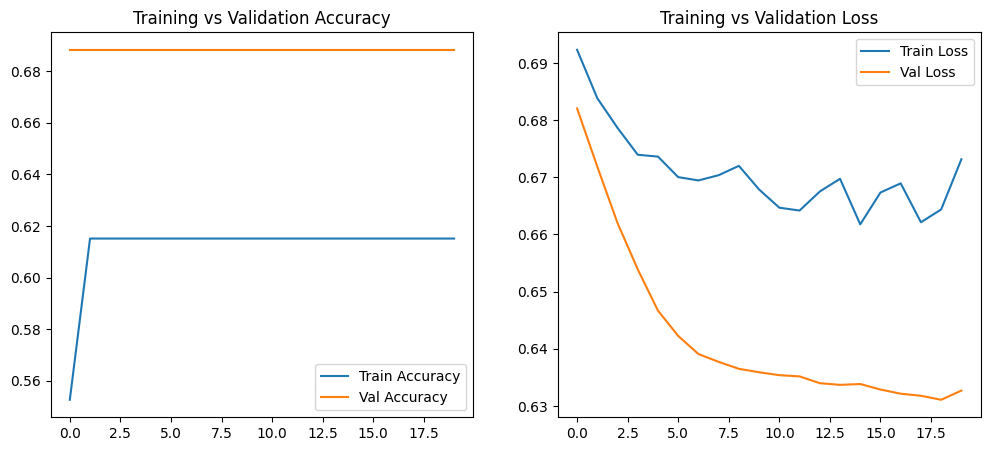

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 


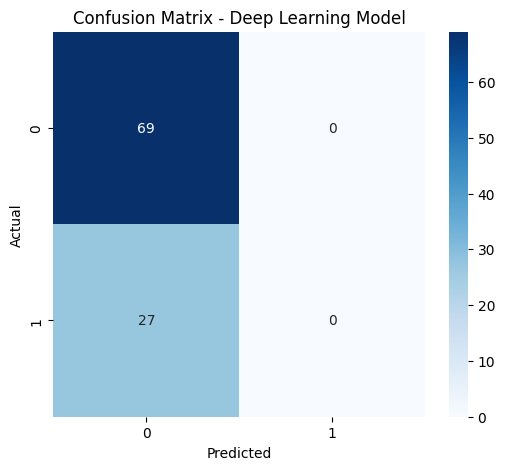

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        69
           1       0.00      0.00      0.00        27

    accuracy                           0.72        96
   macro avg       0.36      0.50      0.42        96
weighted avg       0.52      0.72      0.60        96



C:\Users\HP VICTUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP VICTUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP VICTUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [13]:
# 1. Visualisasi Training vs Validation (Accuracy & Loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# 2. Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Deep Learning Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_8764\4012576470.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='skor', y='tagar', palette='viridis')


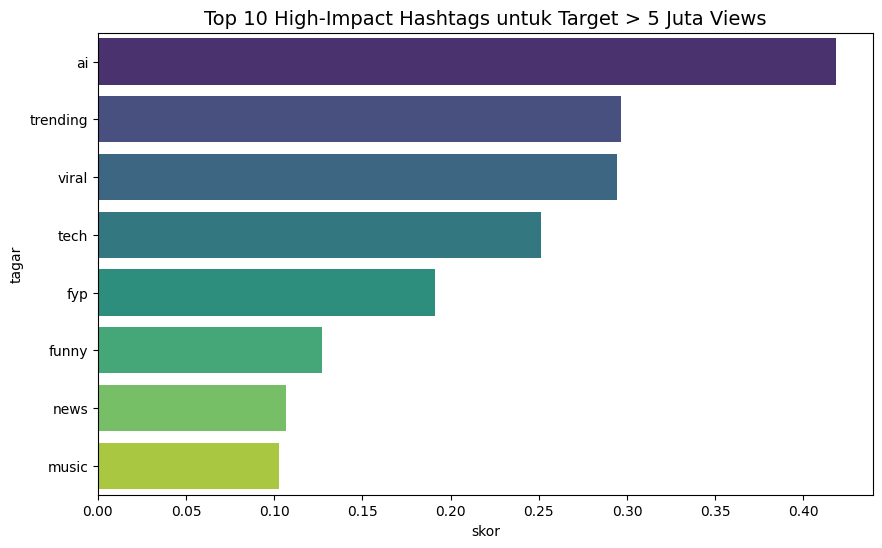

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
--- ANALISIS STRATEGI KAMPANYE ---
Ide Tagar: #tech #ai #ev #future #automotive
Peluang Mencapai Target > 5 Juta Views: 37.85%
STATUS: PERLU REVISI (Pola Kurang Sesuai dengan Target Jangkauan)


In [14]:
# Ekstraksi Bobot Embedding (Semantic Mapping)
weights = model.layers[0].get_weights()[0]
word_index = tokenizer.word_index

importance = []
for word, i in word_index.items():
    if i < max_words:
        score = np.linalg.norm(weights[i])
        importance.append({'tagar': word, 'skor': score})

importance_df = pd.DataFrame(importance).sort_values(by='skor', ascending=False)

# Visualisasi Top 10 Tagar
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='skor', y='tagar', palette='viridis')
plt.title('Top 10 High-Impact Hashtags untuk Target > 5 Juta Views', fontsize=14)
plt.show()

def cek_peluang_viral_otomotif(hashtags_input):
    seq = tokenizer.texts_to_sequences([hashtags_input])
    padded = pad_sequences(seq, maxlen=10)
    prob = model.predict(padded)[0][0]
    
    print(f"--- ANALISIS STRATEGI KAMPANYE ---")
    print(f"Ide Tagar: {hashtags_input}")
    print(f"Peluang Mencapai Target > 5 Juta Views: {prob*100:.2f}%")
    
    if prob > 0.6:
        print("STATUS: SANGAT LAYAK POST (Korelasi Kuat dengan Pola Viral)")
    else:
        print("STATUS: PERLU REVISI (Pola Kurang Sesuai dengan Target Jangkauan)")

# UJI COBA
cek_peluang_viral_otomotif("#tech #ai #ev #future #automotive")